/home/lincy/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



len(hp=13299)


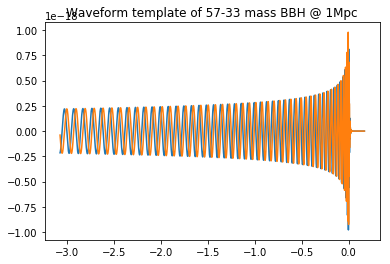

In [1]:
###  
### PyCBC waveform generator
###
#
#  First, let's generate a EOB waveform by PyCBC
#
###
from scipy.interpolate import interp1d
import pycbc.noise
import pycbc.psd
import pycbc.waveform
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab
import numpy as np

RATE = 4096
dt        = 1.0/RATE
apx       = 'SEOBNRv4'
f_low     = 10
m1 = 57
m2 = 33
hp, hc = pycbc.waveform.get_td_waveform(approximant=apx,
        mass1=m1, mass2=m2, spin1z=0, delta_t=dt, f_lower=f_low)
Nt = len(hp)
time = hp.sample_times

plt.plot(time, hp)
plt.plot(time, hc)
plt.title("Waveform template of %d-%d mass BBH @ 1Mpc"%(m1,m2))

print ("len(hp=%d)"%Nt)


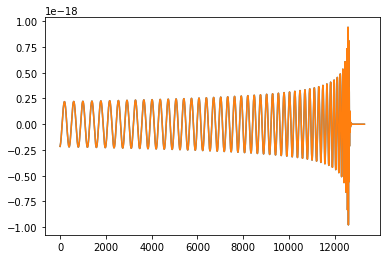

In [2]:
###
###  Here is the code snippet to comfirm the normalization constance of FFT/iFFT
###  Note the freedom in choicing the constant in both FFT/iFFT.
###  However, the ASD==np.sqrt(PSD) should be " np.fft.rfft(hp) * dt ".
###
plt.plot(hp)
freqs2 = np.fft.rfftfreq(Nt, dt)
#hf  = np.fft.rfft(hp)  / RATE
#hff = np.fft.irfft(hf) * RATE
hf  = np.fft.fft(hp)
hff = np.fft.ifft(hf)

#plt.plot(hff)
plt.plot(hp)


In [3]:
###
### Let's also check the frequency bin of FFT and rFFT
###

## N pts with dt, T=dt*(n-1)
npts=20
delta_t=0.1
T=delta_t*(npts)
a=np.fft.rfftfreq(npts, delta_t)
print a
print ("# pts: %d f_pts=%d dt=%f Fmax=%f, df=%f" %( npts, len(a), delta_t, 0.5/delta_t, 1./T))

## N pts with dt, T=dt*(n-1)
npts=20
delta_t=0.1
T=delta_t*(npts)
a=np.fft.fftfreq(npts, delta_t)
print a
print ("# pts: %d f_pts=%d dt=%f Fmax=%f, df=%f" %( npts, len(a), delta_t, 0.5/delta_t, 1./T))


[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
# pts: 20 f_pts=11 dt=0.100000 Fmax=5.000000, df=0.500000
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5 -5.  -4.5 -4.  -3.5
 -3.  -2.5 -2.  -1.5 -1.  -0.5]
# pts: 20 f_pts=20 dt=0.100000 Fmax=5.000000, df=0.500000


1025
[0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]


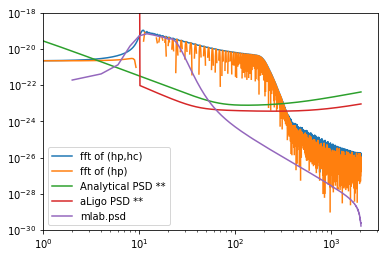

In [14]:
###
### Then, let's play around the LIGO PSD and GW template.
### Note that np.sqrt(PSD) ~ FFT.
### 
### PSD is more smooth then FFT. Smaller NFFT, more high-pass.
###
#
# Whiten GW template
#
def aLIGO_PSD(flow = 10.0, FMAX=8000, delta_f = 1./32., SEED=None):
    flen = int(FMAX / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
    return psd

def aLIGO_PSD_inp(flow = 10.0, FMAX=8000, delta_f = 1./16., SEED=None):
    flen = int(FMAX / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
    #psd = pycbc.psd.analytical.aLIGOZeroDetHighPower(flen, delta_f, flow)
    freqs = psd.sample_frequencies
        
    ## have to tweak the data to avoid 1/0 problem
    sel = np.where( psd.data<1.e-60 )
    psd.data[sel] = 1
        
    psd_interp = interp1d(freqs, psd)

    if 0:
        plt.loglog(freqs, np.sqrt(psd) )
        plt.show()
    
    return psd_interp

def LIGO_PSD_inp(FMAX=8192, delta_f = 1./16.):
    flen = int(FMAX / delta_f) + 1
    freqs = np.linspace(0,FMAX,flen)
    Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
    
    psd_interp = interp1d(freqs, Pxx)
    return psd_interp

from scipy import signal
dwindow1 = signal.tukey(Nt, alpha=0.01)
dwindow = np.blackman(Nt)
if 0:
    plt.plot(dwindow1)
    plt.plot(dwindow)
    plt.show()

### using mlab.psd
#psd, freqs = mlab.psd(hp, Fs = RATE, NFFT = NFFT, window=mlab.window_hanning, noverlap=10)
NFFT=RATE/2
hp_psd, hp_freqs = mlab.psd(hp, Fs = RATE, NFFT = NFFT, noverlap=NFFT/2)

print len(hp_freqs)

### using FFT
f_hf = np.fft.rfftfreq(Nt, dt)
hf = np.fft.rfft(hp*dwindow1) *dt

# Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
print f_hf
psd_ligo  = LIGO_PSD_inp()(f_hf)

### aLIGO PSD
psd_aligo = aLIGO_PSD_inp()(f_hf)

### using complex FFT
f_template_fft = np.fft.fftfreq(Nt, dt)
template = (hp)  # + hc*1.j) 
template_fft = np.fft.fft(template*dwindow1) *dt

###
plt.loglog(f_template_fft, np.abs(template_fft), label="fft of (hp,hc)" ) 
plt.loglog(f_hf, (hf), label="fft of (hp)")
plt.loglog(f_hf, np.sqrt(psd_ligo), label="Analytical PSD **" )
plt.loglog(f_hf, np.sqrt(psd_aligo), label="aLigo PSD **" )
plt.loglog(hp_freqs, np.sqrt(hp_psd), label="mlab.psd")
plt.xlim(1,3096)
plt.ylim(1e-30,1e-18)
plt.legend()

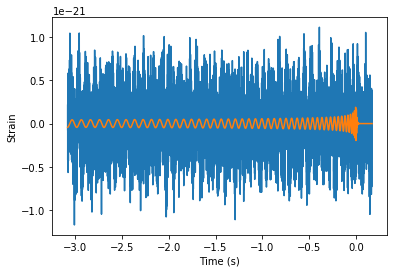

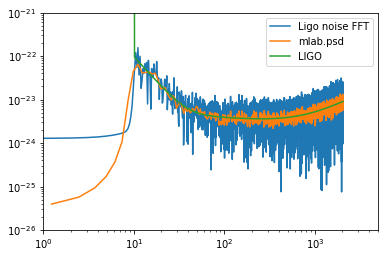

In [5]:
####
####   Now, let's generate noise from LIGO PSD, and calculate the noise PSD compared to the orinigal one.
####
import pycbc.noise
import pycbc.psd
import pylab

# The color of the noise matches a PSD which you provide
# let's start with (f_hf, psd_aligo) in the last cell.

# Generate noise
ligo_ns = pycbc.noise.noise_from_psd(Nt, dt, aLIGO_PSD(), seed=None)

#pylab.plot(ligo_ns.sample_times, ligo_ns, label="aLIGO noise")
#pylab.plot(time, hp/1000, label="waveform/1000")
pylab.plot(time,ligo_ns, label="aLIGO noise")
pylab.plot(time,hp/5000, label="waveform/5000")
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

### FFT the generated noise
ligo_ns_fft = np.fft.rfft(ligo_ns) *dt   ### It is strange that rfft produce complex numbers.    

### PSD
NFFT = Nt//4
ligo_ns_psd, f_ligo_ns = mlab.psd(ligo_ns, Fs = RATE, NFFT = NFFT, window=mlab.window_hanning, noverlap=NFFT//2)

pylab.loglog(f_hf, np.abs(ligo_ns_fft), label="Ligo noise FFT")
pylab.loglog(f_ligo_ns, np.sqrt(ligo_ns_psd), label="mlab.psd")
pylab.loglog(f_hf, np.sqrt(psd_aligo), label="LIGO")
plt.xlim(1,5000)
plt.ylim(1e-26,1e-21)
plt.legend()
pylab.show()

Fmax, df:  2048 1.23225030084
freqs from PSD:  6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]


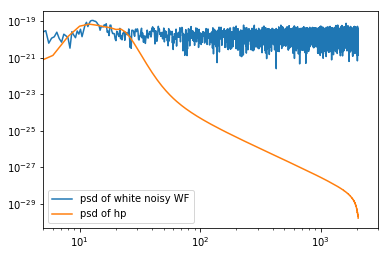

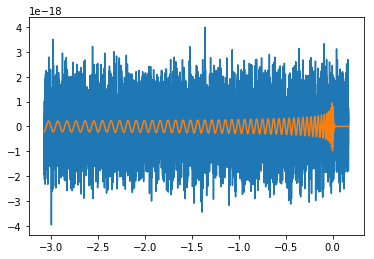

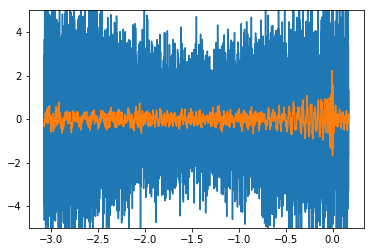

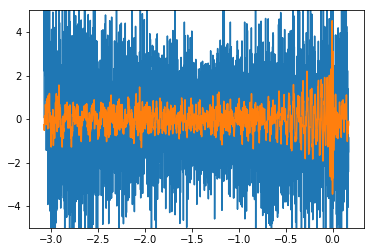

In [6]:
###
###  whitten a (template + gaussian noise) by its own PSD
###

from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

def whiten(strain, interp_psd, dt, bp=0):
    Nt = len(strain)
    f = np.fft.rfftfreq(Nt, dt)
    print len(f), f
    try:    dwindow = signal.tukey(Nt, alpha=0.01)  # Tukey window preferred, but requires recent scipy version 
    except: dwindow = signal.blackman(Nt)          # Blackman window OK if Tukey is not available
    dwindow = 1
    
    hf = np.fft.rfft(strain*dwindow)
    
    norm = np.sqrt(dt*2)
    white_hf = hf / np.sqrt(interp_psd(f)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    
    if bp:
        ## Butterworth D/A filter with 4th-order
        fband = [5.,500.]
        bb, ab = butter(4, [fband[0]*2./RATE, fband[1]*2./RATE], btype='band')
        normalization = np.sqrt((fband[1]-fband[0])/(RATE/2.0))
        white_ht = filtfilt(bb, ab, white_ht) / normalization
        
        if 0:  ## TODO
            plt.figure()
            w, h = signal.freqs(bb, ab)
            plt.plot(w, 20 * np.log10(abs(h)))
            plt.xscale('log')
            plt.title('Butterworth filter frequency response')
            plt.xlabel('Frequency [radians / second]')
            plt.ylabel('Amplitude [dB]')
            plt.margins(0, 0.1)
            plt.grid(which='both', axis='both')
            plt.axvline(100, color='green') # cutoff frequency
            plt.show()

    return white_ht
            
##
data = hp + 1*max(hp)*np.random.normal(0,1,Nt)
Pxx, freqs = mlab.psd(data, Fs=RATE, NFFT=Nt, noverlap=Nt//8)    ## Fmax=RATE/2 ; df=Fs/NFFT
Pxx_inp = interp1d(freqs, Pxx)
print "Fmax, df: ", RATE/2, float(RATE)/NFFT 
print "freqs from PSD: ", len(freqs), freqs

###
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx), label="psd of white noisy WF")
plt.loglog(hp_freqs, np.sqrt(hp_psd), label="psd of hp")
plt.legend()
plt.xlim(5,3000)

##
whiten_data = whiten(data, Pxx_inp, dt, bp=0)
whiten_hp   = whiten(hp  , Pxx_inp, dt, bp=0)
whitenbp_data = whiten(data, Pxx_inp, dt, bp=1)
whitenbp_hp   = whiten(hp  , Pxx_inp, dt, bp=1)


plt.figure()
plt.plot(time, data)
plt.plot(time, hp)
plt.show()

plt.figure()
plt.plot(time, whiten_data)
plt.plot(time, whiten_hp)
plt.ylim(-5,5)
plt.show()

plt.figure()
plt.plot(time, whitenbp_data)
plt.plot(time, whitenbp_hp)
plt.ylim(-5,5)
plt.show()



Fmax, df:  2048 1.0
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]


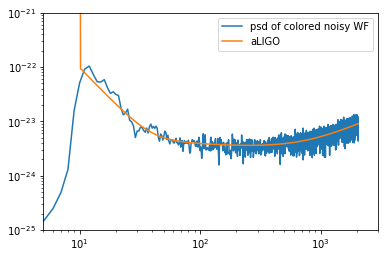

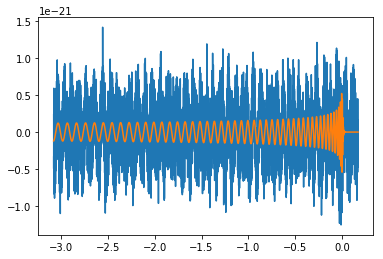

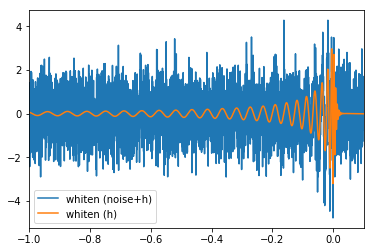

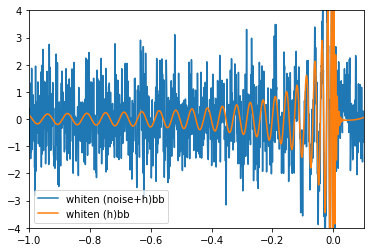

In [11]:
##
###  whitten a (template + LIGO gaussian noise) by its own/LIGO PSD. !!! THIS IS HOW HEURTA DOES THE TEST SET
##
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# Generate noise
ligo_ns = pycbc.noise.noise_from_psd(Nt, dt, aLIGO_PSD(), seed=None)

h = 0.4 * hp.data*max(ligo_ns)/max(hp)
s = ligo_ns.data  + h

## PSD of data   ### NOTE: the choice NFFT affects very much on PSD
NFFT=RATE     
Pxx, freqs = mlab.psd(s, Fs=RATE, NFFT=NFFT, noverlap=NFFT//2)  ## Fmax=RATE/2 ; df=Fs/NFFT
Pxx_inp = interp1d(freqs, Pxx)
print "Fmax, df: ", RATE/2, float(RATE)/NFFT 

###
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx), label="psd of colored noisy WF")
plt.loglog(f_hf, np.sqrt(psd_aligo), label="aLIGO")
plt.legend()
plt.xlim(5,3000)
plt.ylim(1e-25,1e-21)

## Whiten
s_whiten   = whiten(s,  aLIGO_PSD_inp(), dt, bp=0)
h_whiten   = whiten(h,  aLIGO_PSD_inp(), dt, bp=0)
s_whitenbb = whiten(s,  aLIGO_PSD_inp(), dt, bp=1)
h_whitenbb = whiten(h,  aLIGO_PSD_inp(), dt, bp=1)

plt.figure()
plt.plot(time, s)
plt.plot(time, h)
plt.legend()
plt.figure()
plt.plot(time, s_whiten, label="whiten (noise+h)")
plt.plot(time, h_whiten, label="whiten (h)")
plt.xlim(-1,0.1)
plt.legend()
plt.figure()
plt.plot(time, s_whitenbb, label="whiten (noise+h)bb")
plt.plot(time, h_whitenbb, label="whiten (h)bb")
plt.xlim(-1,0.1)
plt.ylim(-4,4)
plt.legend()


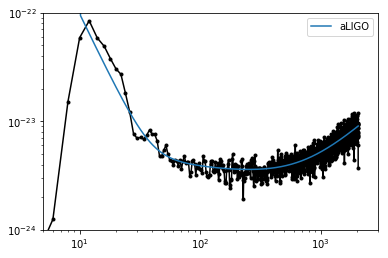

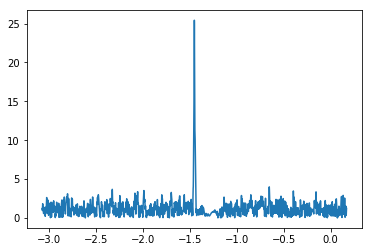

6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
Maximum at -1.4539 with SNR = 25.4, D_eff = 1859.72, horizon = 5910.4 Mpc, Phase:-0.546733860866
13299
13299
13299


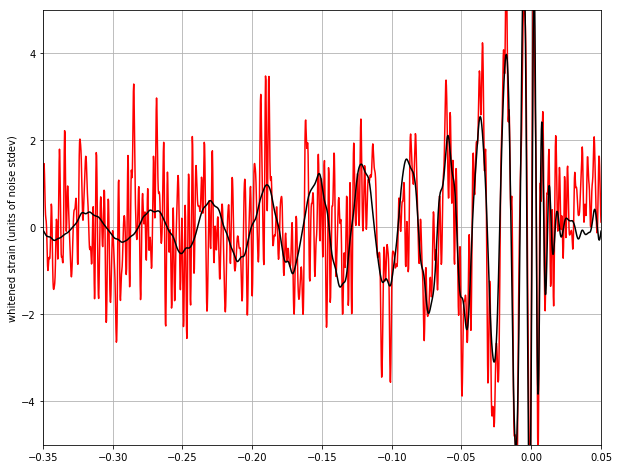

In [12]:
##
##  Next, calculate SNR
##
NFFT=RATE/2
s_psd, f_s = mlab.psd(s, Fs = RATE, NFFT = NFFT, noverlap=NFFT/2) #, window=np.blackman(NFFT) )
if 1:
    plt.figure()
    plt.loglog(f_s, np.sqrt(s_psd), 'k.-')
    plt.loglog(f_hf, np.sqrt(psd_aligo), label="aLIGO")
    plt.legend()
    plt.xlim(5,3000)
    plt.ylim(1e-24,1e-22)
    
template = (hp + hc*1.j) *np.exp(1.j* (0.5)) 
dwindow = signal.tukey(Nt, alpha=1./8)
template_fft = np.fft.fft(template*dwindow) /RATE

s_fft = np.fft.fft(s*dwindow) *dt
sfreq = np.fft.fftfreq(Nt, dt)
df = np.abs(sfreq[1] - sfreq[0])

#power_vec = np.interp(np.abs(sfreq), f_s, s_psd)
power_vec = aLIGO_PSD_inp()( np.abs(sfreq) )

if 0:
    plt.figure()
    plt.loglog(np.abs(datafreq), np.sqrt(power_vec))
    plt.xlim(10,3000)
    plt.ylim(1e-25,1e-22)
    pylab.show()

    
optimal      = s_fft * template_fft.conjugate() / power_vec
optimal_time = 2*np.fft.ifft(optimal)*RATE

if 0:
    plt.figure()
    plt.plot(np.abs(s_fft))
    plt.show()

sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR_complex = optimal_time/sigma

# shift the SNR vector by the template length so that the peak is at the END of the template
peaksample = int(s.size / 2)  # location of peak in the template
SNR_complex = np.roll(SNR_complex,peaksample)
SNR = abs(SNR_complex)

plt.figure()
plt.plot(time,SNR)
plt.show()

# find the time and SNR value at maximum:
indmax = np.argmax(SNR)
timemax = hp.sample_times[indmax]
SNRmax = SNR[indmax]

# Calculate the "effective distance" 
## The effective distance is related to the true distance by several geometrical factors that relate the source
## orientation to the detector orientation. 
# d_eff = (8. / SNRmax)*D_thresh
d_eff = sigma / SNRmax
# -- Calculate optimal horizon distnace
horizon = sigma/8

# Extract time offset and phase at peak
phase = np.angle(SNR_complex[indmax])
offset = (indmax-peaksample)

# apply time offset, phase, and d_eff to template 
template_phaseshifted = np.real( template.data*np.exp(1.j*phase) )    # phase shift the template
template_rolled = np.roll(template_phaseshifted, offset) / d_eff  # Apply time offset and scale amplitude

# Whiten and band-pass the template for plotting
template_match = whiten(template_rolled, interp1d(f_s, s_psd), dt, bp=1)

print('Maximum at {0:.4f} with SNR = {1:.1f}, D_eff = {2:.2f}, horizon = {3:0.1f} Mpc, Phase:{4}' 
      .format(timemax,SNRmax,d_eff,horizon, phase ))

if 1:
    print len(template.data)
    print len(template_rolled)
    print len(template_phaseshifted)

    plt.figure(figsize=(10,8))
    plt.plot(time,s_whitenbb     ,'r', label=' whitened h(t)')
    plt.plot(time,template_match,'k',label='Template')
    plt.ylim([-5,5])
    plt.xlim([-0.35,0.05])
    plt.grid('on')
    plt.ylabel('whitened strain (units of noise stdev)')



In [10]:
def prepare_GW_data(h5name,SNR=1):
  
    HDF5_FILE = h5name
    f = h5py.File(HDF5_FILE,'r')

    keys = f["/waveform"].keys()
    co=0
    x = []
    y = []
    for i in keys[24]:
        i = int(keys[296])
        key = 'waveform/%d'% i
        k1  = 'waveform/%d/t2m'%i
        k2  = 'waveform/%d/hp'%i
    
        m1 = f[key].attrs['m'][0]
        m2 = f[key].attrs['m'][1]
        t2m = f[k1][:]
        hp  = f[k2][:]
        print ("process ...", m1, m2, co)
        co=co+1
    
        leng = len(hp)
        maxhp = max(np.abs(hp))
        print ("MAX: ", maxhp)

        
        ## t0 = 0
        W=RATE
        tm = np.where( t2m >= 0 )[0][0]
        t0 = int(tm - W*0.9 + 1)
        if (t0<0): t0 = 0
            
        ns = maxhp*SNR*(np.random.normal(0,1,W))
        ts = np.zeros(W)
        minhp = min(len(hp)-1, t0+W)
        ns[0:minhp-t0] = ns[0:minhp-t0] + hp[t0:minhp]
        ts[0:minhp-t0] = ts[0:minhp-t0] + hp[t0:minhp]

        psd_real, freq = mlab.psd(ns, Fs = RATE, NFFT = Nt//4, noverlap=Nt//8)

        #_, psd_inp = SignalPSD(T=1.0, RATE=W)
        #_, psd_inp = SignalPSD(T=1.0, RATE=W)
        psd_inp = aLIGO_PSD()
        #psd_inp = LIGO_PSD()

        plt.loglog(freq, np.sqrt(psd_inp(freq)))
        #plt.loglog(freq, psd_real)
        plt.show()    
        
        s_whiten = whiten(ns, psd_inp, 1.0/RATE)
        t_whiten = whiten(ts, psd_inp, 1.0/RATE)
        
        x.append( s_whiten )
        #x.append(hp[t0:t0+W])
        #x.append(maxhp*SNR*np.random.random(W))
        y.append( t_whiten )
        break
    
    f.close()  
    return x,y


x,y = prepare_GW_data('bbh_wftpl_8192.h5', 5)

t=np.linspace(0,1,8192)
plt.figure(figsize=(8,6))
plt.plot(t,x[0],'r',linewidth=.7)
plt.plot(t,y[0],'b',linewidth=.7)
plt.xlim(0,1)

#print(x)
#print(y)


NameError: global name 'h5py' is not defined